In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utility import *
from theoretical import *
from scipy.stats import sem, gmean, norm, expon

# 6.C
Consider a discretely monitored lookback call option with fixed strike price $K$
and maturity $T$. The option payoff is
$$ X = \left( \max_{i=1, ..., m} S_{t_i} - K \right)^+ , $$
where $0 < t_1 < t_2 < ... < t_m = T$ are given dates. Write a function to
compare the performance of the following simulation schemes.

(a) Plain Monte Carlo with sample size $2n$.

(b) Antithetic variates with $n$ pairs of samples.

(c) Control variate method with sample size $2n$. Use $b = \hat{b}^*$, the sample estimate of $b^*$. The control variate is
    i. the underlying stock price;
    ii. the call option with strike price $K$ and maturity $T$;
    iii. the discretely monitored average price call option with geometric mean and maturity $T$, whose payoff is
    $$ Y = (\bar{S}_G - K)^+, \quad \bar{S}_G = \left(\prod_{i = 1}^m S_{t_i}\right)^{1/m}. $$
    iv. the continuous time lookback call option with strike price $K$ and maturity $T$, whose payoff is
    $$ Y = \left( \max_{0 <\leq t \leq T} S_t - K \right)^+.$$


The function should have input parameters $S_0, r, \sigma, K, T, m, (t_1, ..., t_m)$, and $n$.
Report your estimates and standard errors for 
$$ S_0, = 50, r = 0.05, \sigma = 0.2, K = 55, T = 1,$$
$$m = 50, t_i = iT/m, n = 10000.$$

In [6]:
# Setup
np.random.seed(4198)

# Parameters
S_0, r, sig, T = 50, 0.05, 0.2, 1
m, n = 50, 10_000
dt = T / m
t = np.linspace(dt, T, m).reshape(-1, 1)

strike_prices = np.linspace(45, 65, 17)

In [7]:
def plain(K):
    X = np.random.normal(size=(m, 2*n))
    
    sum_X = np.cumsum(X, axis=0)
    S_t = S_0 * np.exp( (r - 0.5 * sig**2) * t + sig * np.sqrt(dt) * sum_X)
    max_S_t = np.max(S_t, axis=0)
    payoff = np.maximum(max_S_t - K, 0)
    discounted_payoff = np.exp(-r * T) * payoff
    
    est = np.mean(discounted_payoff)
    se = sem(discounted_payoff)
    re = se / np.abs(est)

    return est, se, re

In [8]:
def antithetic(K):
    Z = np.random.normal(size=(m, n))
    X = np.concatenate((Z, -Z), axis=1)
    
    sum_X = np.cumsum(X, axis=0)
    S_t = S_0 * np.exp( (r - 0.5 * sig**2) * t + sig * np.sqrt(dt) * sum_X)
    max_S_t = np.max(S_t, axis=0)
    payoff = np.maximum(max_S_t - K, 0)
    discounted_payoff = np.exp(-r * T) * payoff

    est = np.mean(discounted_payoff)
    se = sem(discounted_payoff)
    re = se / np.abs(est)

    return est, se, re


In [9]:
def control_variate_underlying(K):
    Z = np.random.normal(size=(m, n))
    sum_Z = np.cumsum(Z, axis=0)

    S_t = S_0 * np.exp( (r - 0.5 * sig**2) * t + sig * np.sqrt(dt) * sum_Z)
    max_S_t = np.max(S_t, axis=0)
    payoff = np.maximum(max_S_t - K, 0)
    X = np.exp(-r * T) * payoff

    # Underlying asset at maturity as control variate
    Y = np.exp(-r * T) * S_t[-1, :]
    b_star = control_variate_coeffient(X, Y)

    H = X - b_star * (Y - S_0)

    est = np.mean(H)
    se = sem(H)
    re = se / np.abs(est)

    return est, se, re

In [10]:
def control_variate_call_option(K):
    Z = np.random.normal(size=(m, n))
    sum_Z = np.cumsum(Z, axis=0)

    S_t = S_0 * np.exp( (r - 0.5 * sig**2) * t + sig * np.sqrt(dt) * sum_Z)
    max_S_t = np.max(S_t, axis=0)
    payoff = np.maximum(max_S_t - K, 0)
    X = np.exp(-r * T) * payoff

    # Call option as control variate
    Y = np.exp(-r * T) * np.maximum(S_t[-1,:] - K, 0)
    mu_Y = european_call(S_0, K, r, T, sig)
    b_star = control_variate_coeffient(X, Y)

    H = X - b_star * (Y - mu_Y)

    est = np.mean(H)
    se = sem(H)
    re = se / np.abs(est)

    return est, se, re

In [11]:
def control_variate_geom_mean_call_option(K):
    Z = np.random.normal(size=(m, n))
    sum_Z = np.cumsum(Z, axis=0)

    S_t = S_0 * np.exp( (r - 0.5 * sig**2) * t + sig * np.sqrt(dt) * sum_Z)
    max_S_t = np.max(S_t, axis=0)
    payoff = np.maximum(max_S_t - K, 0)
    X = np.exp(-r * T) * payoff

    # Geometric mean call option as control variate
    geom_mean = gmean(S_t, axis=0)
    Y = np.exp(-r * T) * np.maximum(geom_mean - K, 0)
    mu_Y = discretely_monitored_average_price_call_option(S_0, K, r, T, sig, m)
    b_star = control_variate_coeffient(X, Y)

    H = X - b_star * (Y - mu_Y)

    est = np.mean(H)
    se = sem(H)
    re = se / np.abs(est)

    return est, se, re

In [12]:
def control_variate_cts_lookback_call(K):
    Z = np.random.normal(size=(m, n))
    W_t = np.cumsum(np.sqrt(dt) * Z, axis=0)

    S_t = S_0 * np.exp( (r - 0.5 * sig**2) * t + sig * W_t)
    max_S_t = np.max(S_t, axis=0)
    payoff = np.maximum(max_S_t - K, 0)
    X = np.exp(-r * T) * payoff

    # Continuous lookback call option as control variate
    x = np.log(S_t[-1, :]) - np.log(S_0)
    y = expon.rvs(size=n)
    max_X_t = 0.5 * (x + np.sqrt(x**2 + 2*sig**2*T*y))
    Y = np.exp(-r*T) * np.maximum(S_0 * np.exp(max_X_t) - K, 0)

    b_star = control_variate_coeffient(X, Y)
    mu_Y = continuous_lookback_call(S_0, K, r, T, sig)

    H = X - b_star * (Y - mu_Y)

    est = np.mean(H)
    se = sem(H)
    re = se / np.abs(est)

    return est, se, re

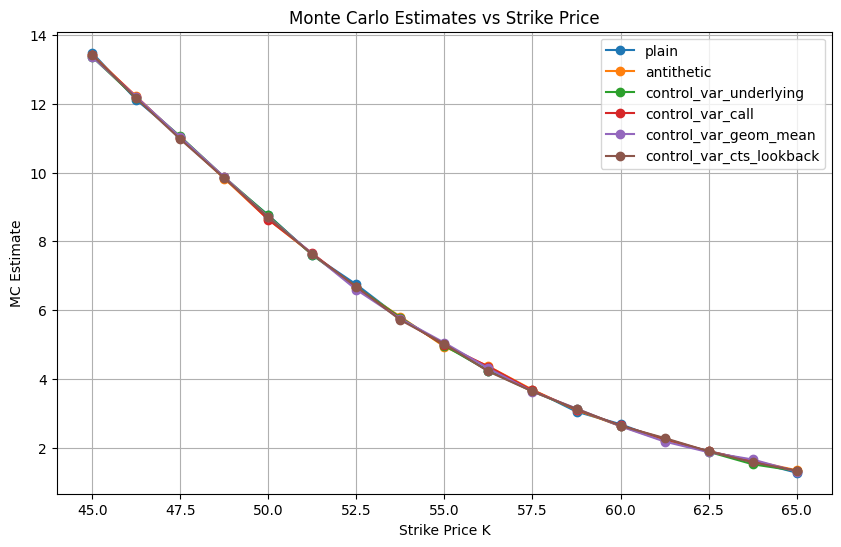

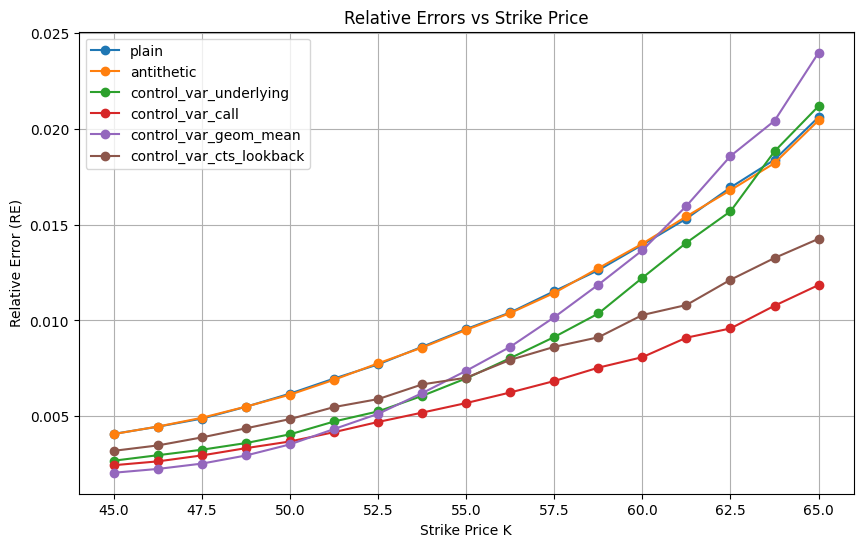

In [14]:
# Prepare storage dictionaries
mc_estimates = {}
res = {}

methods = [
    ("plain", plain),
    ("antithetic", antithetic),
    ("control_var_underlying", control_variate_underlying),
    ("control_var_call", control_variate_call_option),
    ("control_var_geom_mean", control_variate_geom_mean_call_option),
    ("control_var_cts_lookback", control_variate_cts_lookback_call)
]

# Initialize
for name, _ in methods:
    mc_estimates[name] = []
    res[name] = []

# Loop over strikes
for K in strike_prices:
    for name, func in methods:
        # Some functions return 3 or 6 values; unpack the first three
        output = func(K)
        mc_est, se, re = output[:3]
        mc_estimates[name].append(mc_est)
        res[name].append(re)

# Convert lists to arrays
for name in mc_estimates:
    mc_estimates[name] = np.array(mc_estimates[name])
    res[name] = np.array(res[name])

# Plot MC estimates vs strike
plt.figure(figsize=(10,6))
for name in mc_estimates:
    plt.plot(strike_prices, mc_estimates[name], marker='o', linestyle='-', label=name)
    
plt.xlabel("Strike Price K")
plt.ylabel("MC Estimate")

plt.title("Monte Carlo Estimates vs Strike Price")

plt.grid()
plt.legend()

plt.show()

# Plot relative errors vs strike
plt.figure(figsize=(10,6))
for name in res:
    plt.plot(strike_prices, res[name], marker='o', linestyle='-', label=name)

plt.xlabel("Strike Price K")
plt.ylabel("Relative Error (RE)")
plt.title("Relative Errors vs Strike Price")

plt.grid()
plt.legend()

plt.show()
